In [15]:
from dataClasses import *
from cachetools import cached
import copy
import time
import random
from typing import List, Set, Tuple, Dict
import pandas as pd
#import llist
import logging
import pprint
from vrpy import VehicleRoutingProblem
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from util import *
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
from searchAlgorithms import randomLocalSearch, TreeSearch, EvolutionarySearch, EvolutionarySearchBothEchelons
import initialSolutions
warnings.filterwarnings("ignore", module="matplotlib\..*")
warnings.filterwarnings("ignore", module="vrpy\..*")


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%reload_ext autoreload
%autoreload 2


## Initial solution & Depotsolution

In [3]:
def extractDays(hubRoutes, days: list) -> dict:
    res = {}
    for day, dayRoutes in hubRoutes.items():
        if day in days:
            for hubLocID in dayRoutes:
                newID = (day, hubLocID)
                res[newID] = dayRoutes[hubLocID]
    return res

def solveDepot(instance: InstanceCO22, hubRoutes, useDMin = True) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubRoutesDict = hubRoutes.toDict(instance)

    depotRoutes = {}
    
    if useDMin:
        dmin = min([_.daysFresh for _ in instance.Products])
    else: 
        dmin = 1

    for i in range(0, math.ceil(nDays/dmin)):
        periodBegin = dmin*i+1
        periodEnd = dmin*(i+1)+1
        print(i, periodBegin, periodEnd)
        period = list(range(periodBegin, periodEnd))
        periodRoutes = extractDays(hubRoutesDict, period)
        if len(periodRoutes) > 0:  # depot routing
            res = solveDepotVRP(instance, periodRoutes)
            depotRoutes[periodBegin] = res
        else:
            depotRoutes[periodBegin] = {}

    return {'hubRoutes': hubRoutesDict, 'depotRoutes': depotRoutes}

def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"

        truckString = ""
        if day in res['depotRoutes'].keys():
            nTrucks = len(res['depotRoutes'][day])
            for routeID, truckRoute in res['depotRoutes'][day].items():
                truckString += f"{routeID} "
                for i, hubData in enumerate(truckRoute[1:-1]):
                    amountPerProduct = hubData['amounts']
                    truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
                truckString += "\n"
        else:
            nTrucks = 0

        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i += 1
                reqIds = [_['reqID'] for _ in route['route'][1:-1]]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"
        resultString += vanString + "\n"
    return resultString


## Testing evo search

In [74]:
def earlyStopper(costs):
    c = 30
    if len(costs) > c:
        return costs[-1] == costs[-c] 
    return False

i = 29
instance = loadInstance(i)
initialState = initialSolutions.solveHub(instance)
searcher = EvolutionarySearch(instance = instance, initialState = initialState, generationSize=50, candidateSize=300, nGenerations=200)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper)
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/evolutionarysearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

KeyboardInterrupt: 

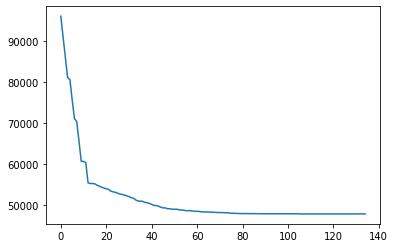

In [61]:
plt.plot(searcher.costs)
#plt.plot([np.var(_) for _ in searcher.allCosts])

In [71]:
bestStateCost

47830.0

In [9]:
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/treesearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 2195 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2212 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2195.0


0 1 5
dict_keys(['10.1', '20.1', '15.1', '8.1', '19.1', '21.1', '6.1', '4.1', '13.1', '7.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2195.0
INFO:vrpy.vrp:iteration 2, 2195.0
INFO:vrpy.vrp:iteration 3, 2195.0
INFO:vrpy.vrp:iteration 4, 2195.0
INFO:vrpy.vrp:iteration 5, 2195.0
INFO:vrpy.vrp:iteration 6, 2195.0
INFO:vrpy.vrp:iteration 7, 2195.0
INFO:vrpy.vrp:iteration 8, 2195.0
INFO:vrpy.vrp:iteration 9, 2195.0
INFO:vrpy.vrp:iteration 10, 2195.0
INFO:vrpy.vrp:iteration 11, 2195.0
INFO:vrpy.vrp:iteration 12, 2195.0
INFO:vrpy.vrp:iteration 13, 2195.0
INFO:vrpy.vrp:iteration 14, 2195.0
INFO:vrpy.vrp:iteration 15, 2195.0
INFO:vrpy.vrp:iteration 16, 2195.0
INFO:vrpy.vrp:iteration 17, 2195.0
INFO:vrpy.vrp:iteration 18, 2195.0
INFO:vrpy.vrp:iteration 19, 2195.0
INFO:vrpy.vrp:iteration 20, 2195.0
INFO:vrpy.vrp:iteration 21, 2195.0
INFO:vrpy.vrp:iteration 22, 2192.0
INFO:vrpy.vrp:iteration 23, 2192.0
INFO:vrpy.vrp:iteration 24, 2192.0
INFO:vrpy.master_solve_pulp:total cost = 2192.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2192 and 1 vehi

1 5 9
dict_keys(['19.1', '20.1', '6.1', '12.1', '15.1', '8.1', '10.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 2, 2192.0
INFO:vrpy.vrp:iteration 3, 2192.0
INFO:vrpy.vrp:iteration 4, 2192.0
INFO:vrpy.vrp:iteration 5, 2192.0
INFO:vrpy.vrp:iteration 6, 2192.0
INFO:vrpy.vrp:iteration 7, 2192.0
INFO:vrpy.vrp:iteration 8, 2192.0
INFO:vrpy.vrp:iteration 9, 2192.0
INFO:vrpy.vrp:iteration 10, 2192.0
INFO:vrpy.vrp:iteration 11, 2192.0
INFO:vrpy.vrp:iteration 12, 2192.0
INFO:vrpy.vrp:iteration 13, 2192.0
INFO:vrpy.vrp:iteration 14, 2192.0
INFO:vrpy.vrp:iteration 15, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2216 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2222 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2216.0
INFO:vrpy.vrp:iteration 1, 2216.0
INFO:vrpy.vrp:iteration 2, 2216.0
INFO:vrpy.vrp:iteration 3, 2216.0
INFO:vrpy.vrp:iteration 4, 2216.0


2 9 13
dict_keys(['2.1', '18.1', '13.1', '7.1', '4.1', '20.1', '21.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2216.0
INFO:vrpy.vrp:iteration 6, 2216.0
INFO:vrpy.vrp:iteration 7, 2216.0
INFO:vrpy.vrp:iteration 8, 2216.0
INFO:vrpy.vrp:iteration 9, 2216.0
INFO:vrpy.vrp:iteration 10, 2216.0
INFO:vrpy.vrp:iteration 11, 2216.0
INFO:vrpy.vrp:iteration 12, 2216.0
INFO:vrpy.vrp:iteration 13, 2216.0
INFO:vrpy.vrp:iteration 14, 2216.0
INFO:vrpy.vrp:iteration 15, 2216.0
INFO:vrpy.vrp:iteration 16, 2216.0
INFO:vrpy.vrp:iteration 17, 2216.0
INFO:vrpy.master_solve_pulp:total cost = 2216.0
INFO:vrpy.vrp:new upper bound : max num stops = 8
INFO:vrpy.vrp:Clarke & Wright solution found with value 2206 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2217 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2206.0
INFO:vrpy.vrp:iteration 1, 2206.0
INFO:vrpy.vrp:iteration 2, 2206.0
INFO:vrpy.vrp:iteration 3, 2206.0
INFO:vrpy.vrp:iteration 4, 2206.0


3 13 17
dict_keys(['12.1', '15.1', '11.1', '6.1', '18.1', '19.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2206.0
INFO:vrpy.vrp:iteration 6, 2206.0
INFO:vrpy.vrp:iteration 7, 2206.0
INFO:vrpy.vrp:iteration 8, 2206.0
INFO:vrpy.vrp:iteration 9, 2206.0
INFO:vrpy.master_solve_pulp:total cost = 2206.0
INFO:vrpy.vrp:new upper bound : max num stops = 10
INFO:vrpy.vrp:Clarke & Wright solution found with value 2189 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2203 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2189.0


4 17 21
dict_keys(['18.1', '10.1', '7.1', '20.1', '4.1', '13.1', '8.1', '2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2189.0
INFO:vrpy.vrp:iteration 2, 2189.0
INFO:vrpy.vrp:iteration 3, 2189.0
INFO:vrpy.vrp:iteration 4, 2189.0
INFO:vrpy.vrp:iteration 5, 2189.0
INFO:vrpy.vrp:iteration 6, 2189.0
INFO:vrpy.vrp:iteration 7, 2189.0
INFO:vrpy.vrp:iteration 8, 2189.0
INFO:vrpy.vrp:iteration 9, 2189.0
INFO:vrpy.vrp:iteration 10, 2189.0
INFO:vrpy.vrp:iteration 11, 2189.0
INFO:vrpy.vrp:iteration 12, 2189.0
INFO:vrpy.vrp:iteration 13, 2189.0
INFO:vrpy.vrp:iteration 14, 2189.0
INFO:vrpy.vrp:iteration 15, 2189.0
INFO:vrpy.vrp:iteration 16, 2189.0
INFO:vrpy.vrp:iteration 17, 2189.0
INFO:vrpy.vrp:iteration 18, 2189.0
INFO:vrpy.vrp:iteration 19, 2189.0
INFO:vrpy.vrp:iteration 20, 2189.0
INFO:vrpy.vrp:iteration 21, 2189.0
INFO:vrpy.vrp:iteration 22, 2189.0
INFO:vrpy.vrp:iteration 23, 2189.0
INFO:vrpy.vrp:iteration 24, 2189.0
INFO:vrpy.vrp:iteration 25, 2189.0
INFO:vrpy.vrp:iteration 26, 2189.0
INFO:vrpy.vrp:iteration 27, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0


## testing complete solution evo search

In [72]:
def earlyStopper(costs):
    c = 30
    if len(costs) > c:
        return costs[-1] == costs[-c] 
    return False

i = 26
instance = loadInstance(i)
hubRoutes = initialSolutions.solveHub(instance)
depotRoutes = initialSolutions.solveDepotDC(instance, hubRoutes)
initialState = Solution(hubRoutes=hubRoutes, depotRoutes=depotRoutes)
searcher = EvolutionarySearchBothEchelons(instance = instance, initialState = initialState, generationSize=10, candidateSize=50)
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=False, nGenerations=80) #warmup
bestState, bestStateCost = searcher.run(parallel=False, earlyStopping= earlyStopper, recomputeDepotRoute=True, nGenerations=40)

Recomputing depot route: False, using depot route cost: True, initialStateCost: 216575.0
Generation 1 - Size: 10 bestCost: 215835.0 generationCostVariance: 230.13 elapsed: 1.67
Generation 2 - Size: 10 bestCost: 215775.0 generationCostVariance: 232.48 elapsed: 0.40
Generation 3 - Size: 10 bestCost: 215595.0 generationCostVariance: 179.28 elapsed: 0.46
Generation 4 - Size: 10 bestCost: 215165.0 generationCostVariance: 181.97 elapsed: 0.63
Generation 5 - Size: 10 bestCost: 210715.0 generationCostVariance: 1420.03 elapsed: 0.48
Generation 6 - Size: 10 bestCost: 210615.0 generationCostVariance: 1809.07 elapsed: 0.41
Generation 7 - Size: 10 bestCost: 210370.0 generationCostVariance: 2026.90 elapsed: 0.64
Generation 8 - Size: 10 bestCost: 209860.0 generationCostVariance: 319.28 elapsed: 0.39
Generation 9 - Size: 10 bestCost: 205255.0 generationCostVariance: 1452.36 elapsed: 0.40
Generation 10 - Size: 10 bestCost: 205255.0 generationCostVariance: 2057.37 elapsed: 0.66
Generation 11 - Size: 10 

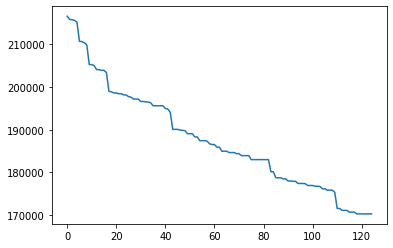

In [73]:
plt.plot(searcher.costs)

In [71]:
solutionStr = bestState.toStr(instance)
with open(f"./solutions/evolutionarysearch2E/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

In [46]:
solutionStr = initialState.toStr(instance)
with open(f"./solutions/evolutionarysearch2E/solution{i}_initialState.txt", 'w') as file:
    file.write(solutionStr)

In [47]:
initialState.computeCost(instance, hubCost=True, depotCost = True, distanceMatrix  = DistanceMatrix(instance), useHubOpeningCost=True)

148230.0